# Data Cleansing with R

In [1]:
library(dplyr)
library(ggplot2)
if(!require(ggExtra)) {install.packages("ggExtra");require(ggExtra)}
if(!require(naniar)) {install.packages("naniar");require(naniar)}
if(!require(mvoutlier)) {install.packages("mvoutlier");require(mvoutlier)}
if(!require(MissMech)) {install.packages("MissMech");require(MissMech)}
if(!require(mice)) {install.packages("mice");require(mice)}
if(!require(MatchIt)) {install.packages("MatchIt");require(MatchIt)}


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggExtra

Loading required package: naniar

Loading required package: mvoutlier

Loading required package: sgeostat

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

sROC 0.1-2 loaded

Loading required package: MissMech

Loading required package: mice

Loading required package: lattice

Registered S3 methods overwritten by 'lme4':
  method                          from
  cooks.distance.influence.merMod car 
  influence.merMod                car 
  dfbeta.influence.merMod         car 
  dfbetas.influence.merMod        car 


Attaching package: ‘mice’


The following objects are masked from ‘package:base’:

    cbind, rbind


Loading required package: MatchIt



In [5]:
outlierMatrix <- function(data,threshold=1.5) {
    vn <- names(data)
    outdata <- data.frame(row1=1:nrow(data))
    for(v in vn) {
        if(is.numeric(data[[v]])) {
            med <- median(data[[v]],na.rm = TRUE)
            outlow <- quantile(data[[v]],probs = 0.25,na.rm = T) 
            outhigh <- quantile(data[[v]],probs = 0.75, na.rm = T)
            irq_level <- (outhigh - outlow) * threshold
            outlow <- outlow - irq_level
            outhigh <- outhigh +  irq_level
            mv <- ifelse(data[[v]] < outlow | data[[v]] > outhigh, 1, 0)
            outdata[v] <- mv
        } else {
            mv <- rep(0,nrow(data))
        }
    }
    outdata$row1 <- NULL
    return(outdata)
}


missingMatrix <- function(data) {
    vn <- names(data)
    missdata <- data.frame(row1=1:nrow(data))
    for(v in vn) {
        mv <- ifelse(is.na(data[[v]]),1,0)
        missdata[v] <- mv
    }
    missdata$row1 <- NULL
    return(missdata)
}

minmax <- function(x) {
    return(((x-min(x,na.rm=T))/(max(x,na.rm=T)-min(x,na.rm=T))))
}

getMissingness <- function (data, getRows = FALSE) {
    require(dplyr)
    l <- nrow(data)
    vn <- names(data)
    nadf <- data
    cnt <- NULL
    miss <- function(x) return(sum(is.na(x)))
    for (n in vn) {
        nadf[[n]] <- ifelse(is.na(nadf[[n]]) == T, 1, 0)
        cnt <- rbind(cnt, data.frame(n, sum(nadf[[n]])))
    }
    names(cnt) <- c("var", "na.count")
    cnt$rate <- round((cnt$na.count/nrow(nadf)) * 100, 1)
    nadf$na.cnt <- 0
    nadf$na.cnt <- rowSums(nadf)
    cnt <- cnt %>% dplyr::arrange(desc(na.count)) %>% dplyr::filter(na.count > 
        0)
    totmiss <- nadf %>% dplyr::filter(na.cnt == 0) %>% dplyr::tally()
    idx <- NULL
    msg <- (paste("This dataset has ", as.character(totmiss), 
        " (", as.character(round(totmiss/nrow(data) * 100, 1)), 
        "%)", " complete rows. Original data has ", nrow(data), 
        " rows.", sep = ""))
    if (getRows == TRUE & totmiss != 0) {
        nadf$rn <- seq_len(nrow(data))
        idx <- nadf %>% dplyr::filter(na.cnt == 0) %>% dplyr::select(rn)
    }
    print(list(head(cnt, n = 10), msg))
    return(list(missingness = cnt, message = msg, rows = idx$rn))
}

In [14]:
### load data

animals = read.csv("../data/mammalsleep.csv")
animals$X <- NULL
head(animals)

species,bw,brw,sws,ps,ts,mls,gt,pi,sei,odi
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
African elephant,6654.000,5712.0,NA,NA,3.3,38.6,645,3,5,3
African giant pouched rat,1.000,6.6,6.3,2.0,8.3,4.5,42,3,1,3
Arctic Fox,3.385,44.5,NA,NA,12.5,14.0,60,1,1,1
Arctic ground squirrel,0.920,5.7,NA,NA,16.5,NA,25,5,2,3
Asian elephant,2547.000,4603.0,2.1,1.8,3.9,69.0,624,3,5,4
Baboon,10.550,179.5,9.1,0.7,9.8,27.0,180,4,4,4


<u>Mammal Sleep Dataset</u>

<table>
    <tr><th>species</th><td>Species of animal</td></tr>
    <tr><th>bw</th><td> Body weight (kg)</td></tr>
    <tr><th>brw</th><td> Brain weight (g)</td></tr>
    <tr><th>sws</th><td> Slow wave ("nondreaming") sleep (hrs/day)</td></tr>
    <tr><th>ps</th><td> Paradoxical ("dreaming") sleep (hrs/day)</td></tr>
    <tr><th>ts</th><td> Total sleep (hrs/day) (sum of slow wave and paradoxical sleep)</td></tr>
    <tr><th>mls</th><td> Maximum life span (years)</td></tr>
    <tr><th>gt</th><td> Gestation time (days)</td></tr>
    <tr><th>pi</th><td> Predation index (1-5), 1 = least likely to be preyed upon</td></tr>
    <tr><th>sei</th><td> Sleep exposure index (1-5), 1 = least exposed (e.g. animal sleeps in a well-protected den), 5 = most exposed</td></tr>
    <tr><th>odi</th><td> Overall danger index (1-5) based on the above two indices and other information, 1 = least danger (from other animals), 5 = most danger (from other animals)</td></tr>
</table>


# Outliers

## Univariate Outliers

In [5]:
## Using IRQ for catching univariate outliers (1.5 x IRQ)
head(outlierMatrix(animals,threshold=1.5))

bw,brw,sws,ps,ts,mls,gt,pi,sei,odi
1,1,NA,NA,0,0,1,0,0,0
0,0,0,0,0,0,0,0,0,0
0,0,NA,NA,0,0,0,0,0,0
0,0,NA,NA,0,NA,0,0,0,0
1,1,0,0,0,1,1,0,0,0
0,0,0,0,0,0,0,0,0,0


In [6]:
## Using IRQ for catching univariate outliers (1.5 x IRQ)
head(outlierMatrix(animals,threshold=2.0))

bw,brw,sws,ps,ts,mls,gt,pi,sei,odi
1,1,NA,NA,0,0,1,0,0,0
0,0,0,0,0,0,0,0,0,0
0,0,NA,NA,0,0,0,0,0,0
0,0,NA,NA,0,NA,0,0,0,0
1,1,0,0,0,0,1,0,0,0
0,0,0,0,0,0,0,0,0,0


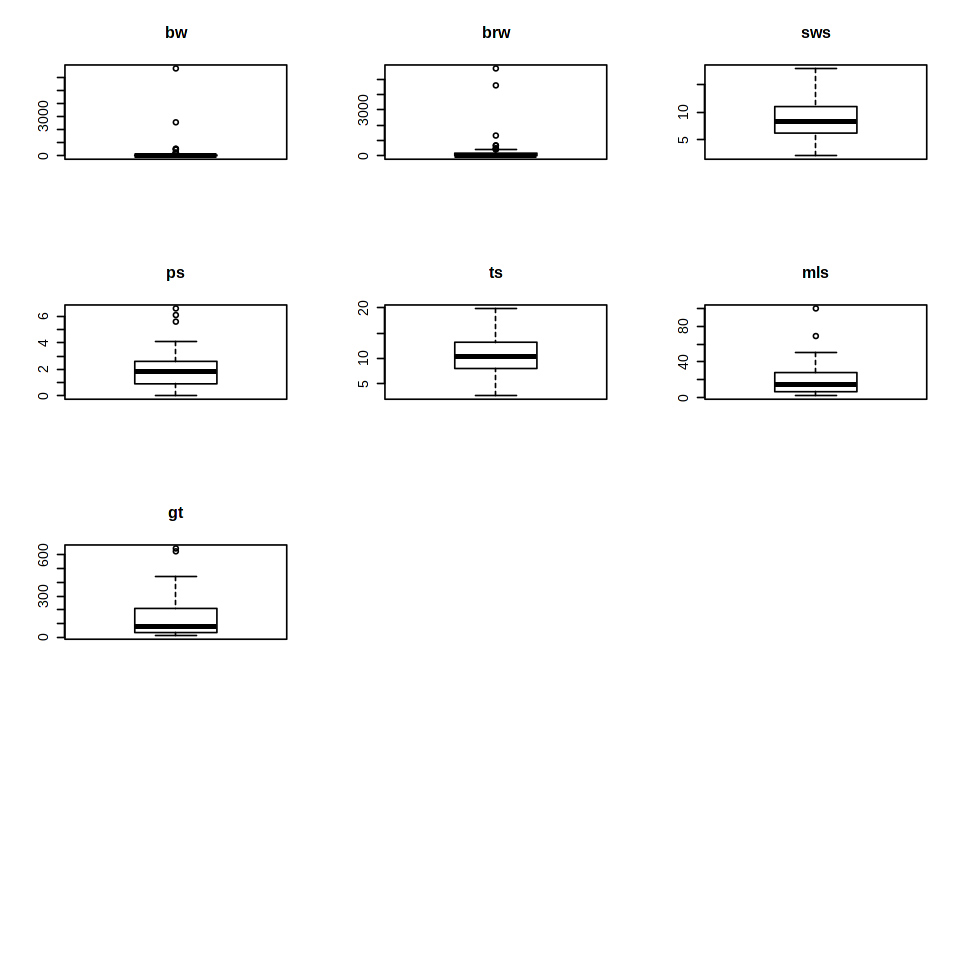

In [7]:
## Visual determination of univariate outliers using boxplots 
options(repr.plot.width = 8, repr.plot.height = 8)
par(mfrow=c(4,3))
for(v in names(animals[,2:8])) {
    boxplot(animals[[v]],main=v)
}
par(mfrow=c(1,1))


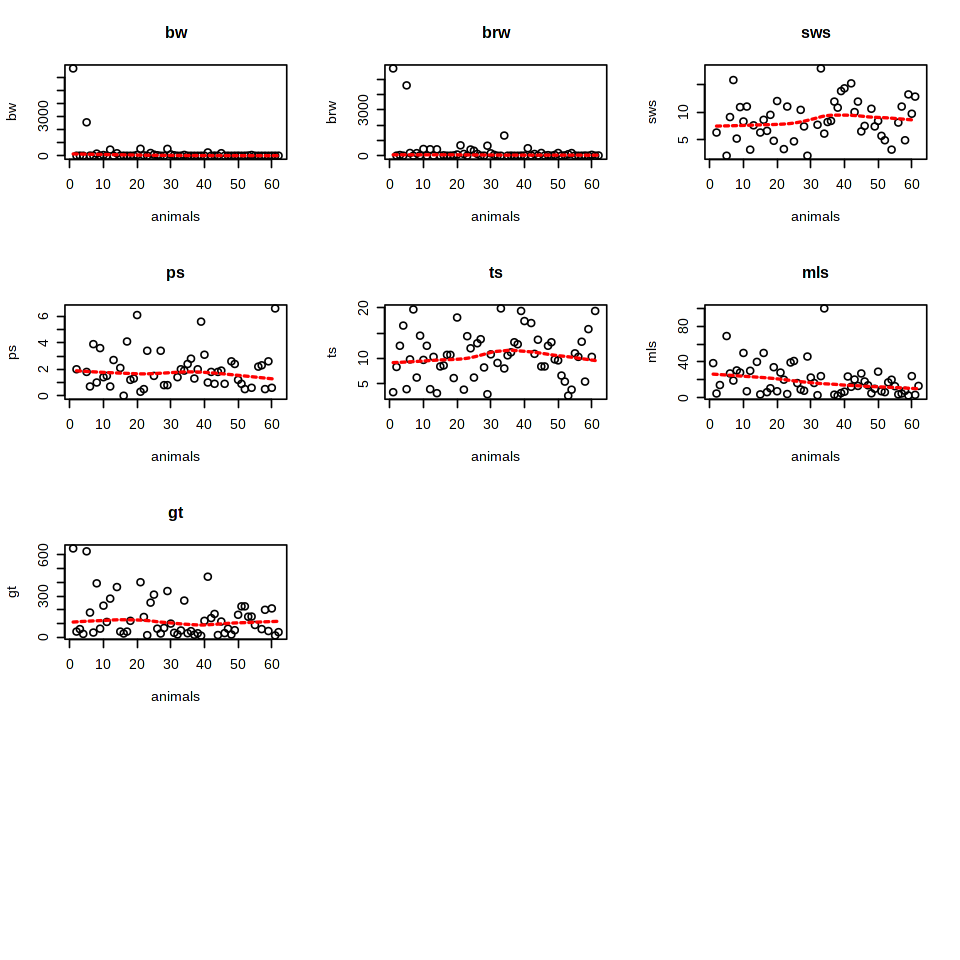

In [8]:
## Visual determination of univariate outliers using scatter plots X axis is the index
options(repr.plot.width = 8, repr.plot.height = 8)
par(mfrow=c(4,3))
for(v in names(animals[,2:8])) {
    scatter.smooth(animals[[v]] ~ animals$species, main=v, xlab="animals",ylab=v, family="symmetric",
                  lpars =list(col = "red", lwd = 2, lty = 2))
}
par(mfrow=c(1,1))


## Multivariate Outliers
 
### Detecting multivariate outliers using DBSCAN

In [20]:
## dbscan
if(!require(dbscan)){install.packages("dbscan");require(dbscan)}
library(dbscan)
# normalize the numbers
animals.norm <- sapply(animals[,2:ncol(animals)], minmax)

In [21]:
head(animals)

species,bw,brw,sws,ps,ts,mls,gt,pi,sei,odi
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
African elephant,6654.000,5712.0,NA,NA,3.3,38.6,645,3,5,3
African giant pouched rat,1.000,6.6,6.3,2.0,8.3,4.5,42,3,1,3
Arctic Fox,3.385,44.5,NA,NA,12.5,14.0,60,1,1,1
Arctic ground squirrel,0.920,5.7,NA,NA,16.5,NA,25,5,2,3
Asian elephant,2547.000,4603.0,2.1,1.8,3.9,69.0,624,3,5,4
Baboon,10.550,179.5,9.1,0.7,9.8,27.0,180,4,4,4


In [22]:
head(animals.norm)

bw,brw,sws,ps,ts,mls,gt,pi,sei,odi
1.0000000000,1.0000000000,NA,NA,0.04046243,0.3734694,1.00000000,0.50,1.00,0.50
0.0001495342,0.0011309801,0.2658228,0.3030303,0.32947977,0.0255102,0.04739336,0.50,0.00,0.50
0.0005079655,0.0077662968,NA,NA,0.57225434,0.1224490,0.07582938,0.00,0.00,0.00
0.0001375114,0.0009734132,NA,NA,0.80346821,NA,0.02053712,1.00,0.25,0.50
0.3827768130,0.8058425802,0.0000000,0.2727273,0.07514451,0.6836735,0.96682464,0.50,1.00,0.75
0.0015847622,0.0314013299,0.4430380,0.1060606,0.41618497,0.2551020,0.26540284,0.75,0.75,0.75


In [23]:
mm <- getMissingness(animals, getRows = T)
head(mm$rows)

[[1]]
  var na.count rate
1 sws       14 22.6
2  ps       12 19.4
3  ts        4  6.5
4 mls        4  6.5
5  gt        4  6.5

[[2]]
[1] "This dataset has 42 (67.7%) complete rows. Original data has 62 rows."



[1] 2 5 6 7 8 9

In [26]:
mm

var,na.count,rate
<fct>,<dbl>,<dbl>
sws,14,22.6
ps,12,19.4
ts,4,6.5
mls,4,6.5
gt,4,6.5


mm

In [24]:
mod <- dbscan(animals.norm[mm$rows,], eps=0.5, minPts = 4)
table(mod$cluster)
#0 is the group of outlayers


 0  1  2 
 6 23 13 

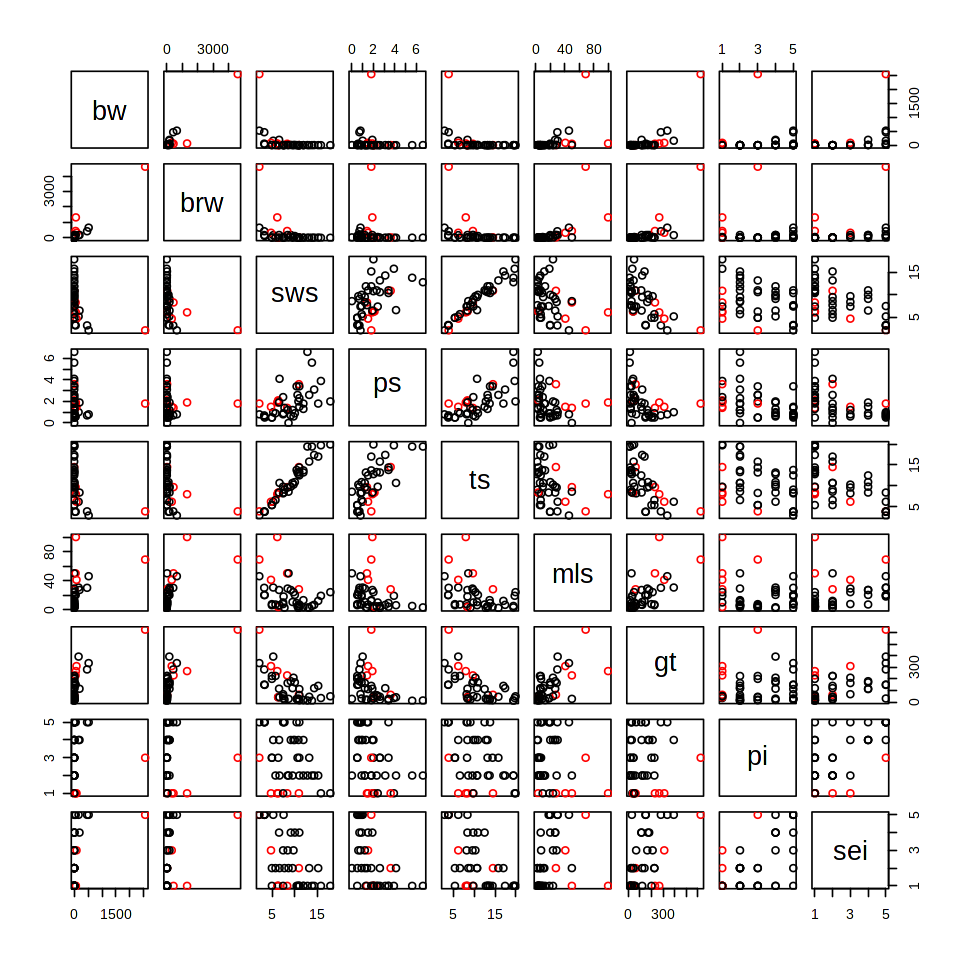

In [28]:
#the red dots represents outlayers
options(repr.plot.width = 8, repr.plot.height = 8)
pairs(animals[mm$rows,2:ncol(animals.norm)], col=ifelse(mod$cluster==0,2,1))


### Detecting multivariate outliers using Chi-squre distance plot

Warning message in covMcd(x, alpha = quan):
“The covariance matrix of the data is singular.
There are 42 observations (in the entire dataset of 42 obs.) lying on
the hyperplane with equation a_1*(x_i1 - m_1) + ... + a_p*(x_ip - m_p)
= 0 with (m_1, ..., m_p) the mean of these observations and
coefficients a_i from the vector a <- c(0, -0.6491074, -0.2711461,
0.7107315, 0)”

NULL

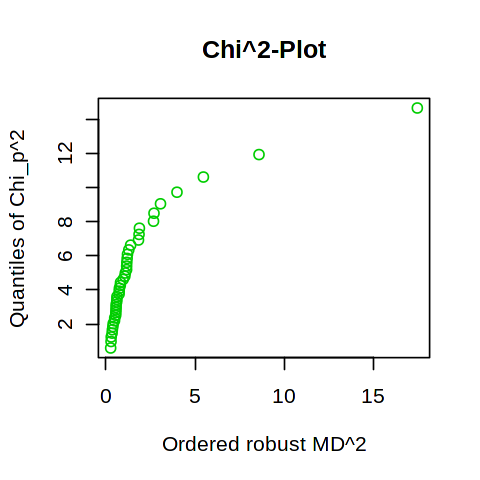

In [14]:
## just for example - no need to know deeply
options(repr.plot.width = 4, repr.plot.height = 4)
res <-chisq.plot(animals.norm[mm$rows,2:6],ask=F)
res$outliers

### Detecting multivariate outliers using DIstance-Distance plots
 
This plot measures the distance between a point and a distribution to which that point belongs. To do this it uses the Mahalonobis distance
 

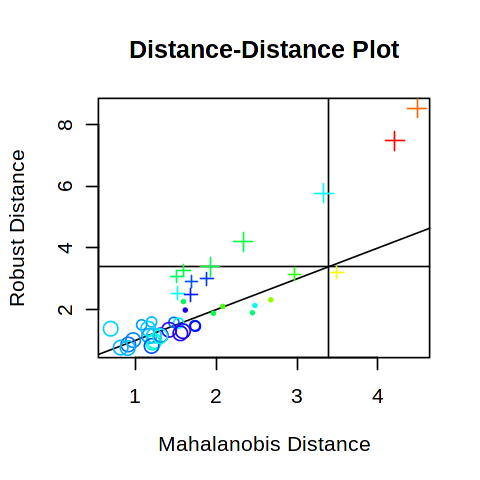

In [21]:
## Distance-Distance plot for outlier detection
options(repr.plot.width = 4, repr.plot.height = 4)
animals2 <- animals[mm$rows,c(4,5,7,8)]
distances <- dd.plot(animals2, quan=1/2, alpha=0.025)

## Multivariate Outliers detection using PCA

In [22]:
animals.pca <- prcomp(animals[mm$rows,2:ncol(animals)])

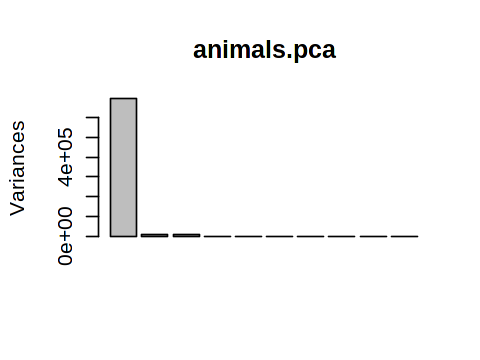

In [23]:
options(repr.plot.width = 4, repr.plot.height = 3)
plot(animals.pca)

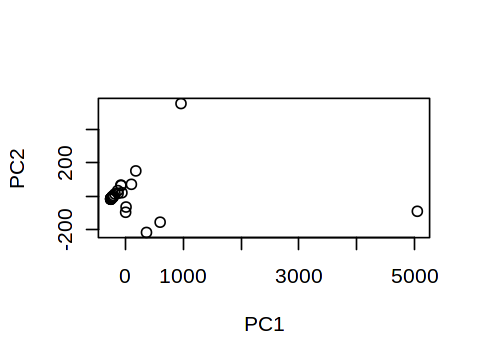

In [24]:
plot(animals.pca$x)

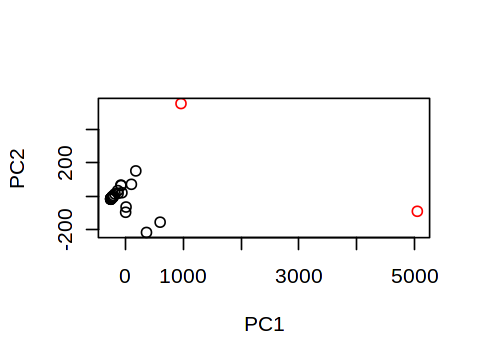

In [25]:
outliers <- ifelse(animals.pca$x[,1]>800,2,1)
plot(animals.pca$x, col=outliers)

# Missingness

In [26]:
head(missingMatrix(animals))

species,bw,brw,sws,ps,ts,mls,gt,pi,sei,odi
0,0,0,1,1,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0
0,0,0,1,1,0,0,0,0,0,0
0,0,0,1,1,0,1,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0


## Missing values visualization

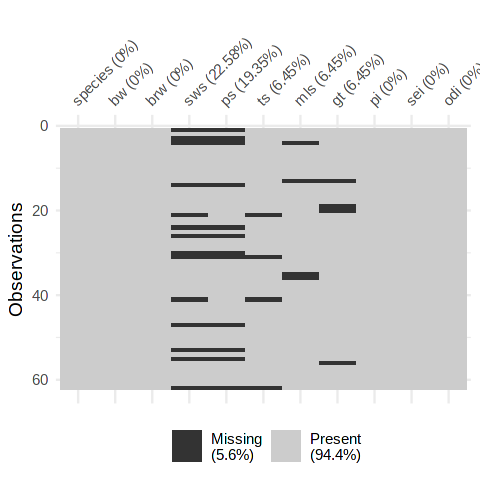

In [27]:
options(repr.plot.width = 4, repr.plot.height = 4)
vis_miss(animals)

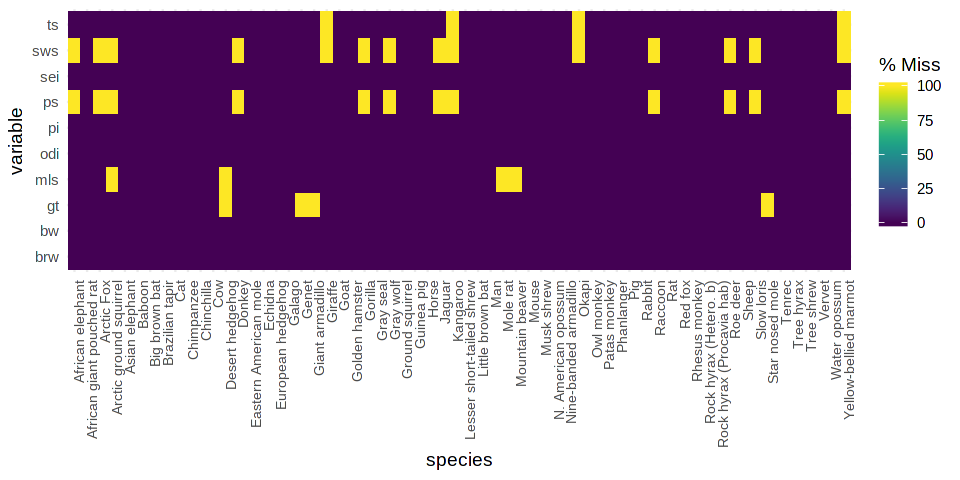

In [28]:
# require(naniar)
options(repr.plot.width = 8, repr.plot.height = 4)
gg_miss_fct(x=animals, fct=species) + 
theme(axis.text.x = element_text(angle=90, size=8))

## Determinate the Missingness Generation Mechanism
 
There are three mechanisms that generate Missing values:
 
1. Missing Completely at Random (MCAR)
2. Missing at Random (MAR)
3. Missing not at Random (MNAR)
 
We will investigate the missingness mechanisms using different techniques.


In [29]:
# require(MissMech)
animals2 <- animals[,c(4,5,7,8)]
miss1 <- TestMCARNormality(data=animals2)
miss1

Call:
TestMCARNormality(data = animals2)

Number of Patterns:  2 

Total number of cases used in the analysis:  53 

 Pattern(s) used:
          sws   ps   mls   gt   Number of cases
group.1    NA   NA     1    1                11
group.2     1    1     1    1                42


    Test of normality and Homoscedasticity:
  -------------------------------------------

Hawkins Test:

    P-value for the Hawkins test of normality and homoscedasticity:  0.01490687 

    Either the test of multivariate normality or homoscedasticity (or both) is rejected.
    Provided that normality can be assumed, the hypothesis of MCAR is 
    rejected at 0.05 significance level. 

Non-Parametric Test:

    P-value for the non-parametric test of homoscedasticity:  0.7774449 

    Reject Normality at 0.05 significance level.
    There is not sufficient evidence to reject MCAR at 0.05 significance level.

In [30]:
### Impute missing values

miss1 <- TestMCARNormality(data=animals2, , del.lesscases = 1, imputation.number = 10)
summary(miss1)



Number of imputation:  10 

Number of Patterns:  5 

Total number of cases used in the analysis:  60 

 Pattern(s) used:
          sws   ps   mls   gt   Number of cases
group.1    NA   NA     1    1                11
group.2     1    1     1    1                42
group.3     1    1     1   NA                 3
group.4    NA    1     1    1                 2
group.5     1    1    NA    1                 2


    Test of normality and Homoscedasticity:
  -------------------------------------------

Hawkins Test:

    P-value for the Hawkins test of normality and homoscedasticity:  0.0002455909 

Non-Parametric Test:

    P-value for the non-parametric test of homoscedasticity:  0.007601006 


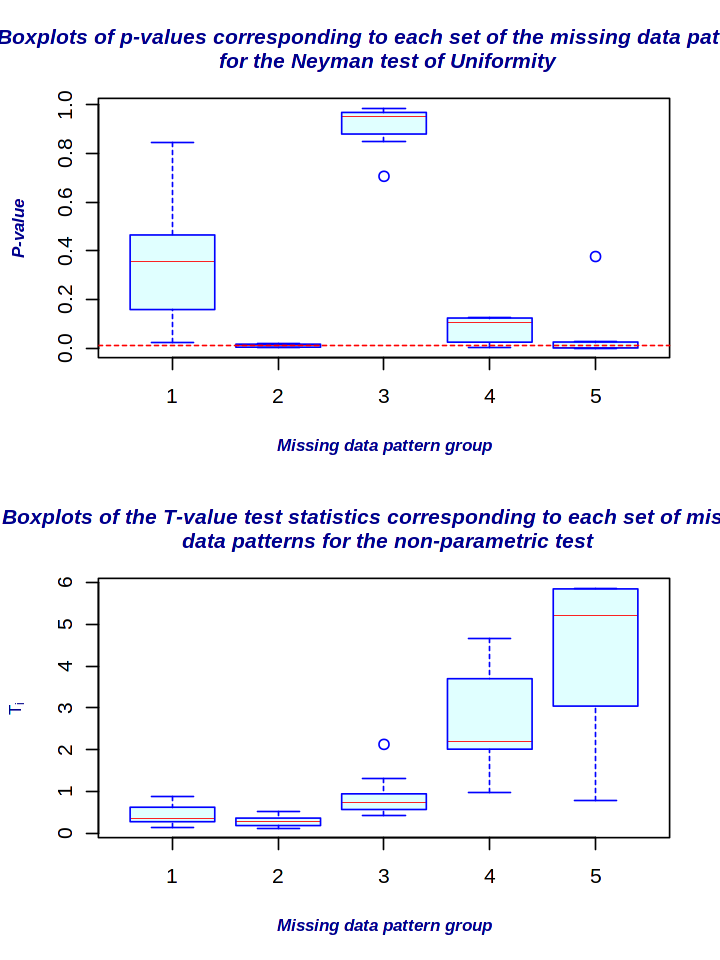

In [31]:
options(repr.plot.width = 6, repr.plot.height = 8)
boxplot(miss1)

In [32]:
summary(miss1$imputed.data)

animals.imp <- data.frame(miss1$imputed.data)
idx <- miss1$caseorder

head(animals.imp)
dim(animals.imp)

      sws               ps               mls                gt        
 Min.   : 1.968   Min.   :-0.2537   Min.   :  2.000   Min.   : 12.00  
 1st Qu.: 5.909   1st Qu.: 0.9000   1st Qu.:  6.375   1st Qu.: 37.25  
 Median : 8.350   Median : 1.8000   Median : 13.850   Median : 79.00  
 Mean   : 8.491   Mean   : 1.9477   Mean   : 19.472   Mean   :142.05  
 3rd Qu.:11.000   3rd Qu.: 2.4595   3rd Qu.: 27.250   3rd Qu.:213.75  
 Max.   :17.900   Max.   : 6.6000   Max.   :100.000   Max.   :645.00  

sws,ps,mls,gt
4.676520,0.7918756,38.6,645
6.300000,2.0000000,4.5,42
5.979087,2.0135957,14.0,60
2.100000,1.8000000,69.0,624
9.100000,0.7000000,27.0,180
15.800000,3.9000000,19.0,35


[1] 60  4

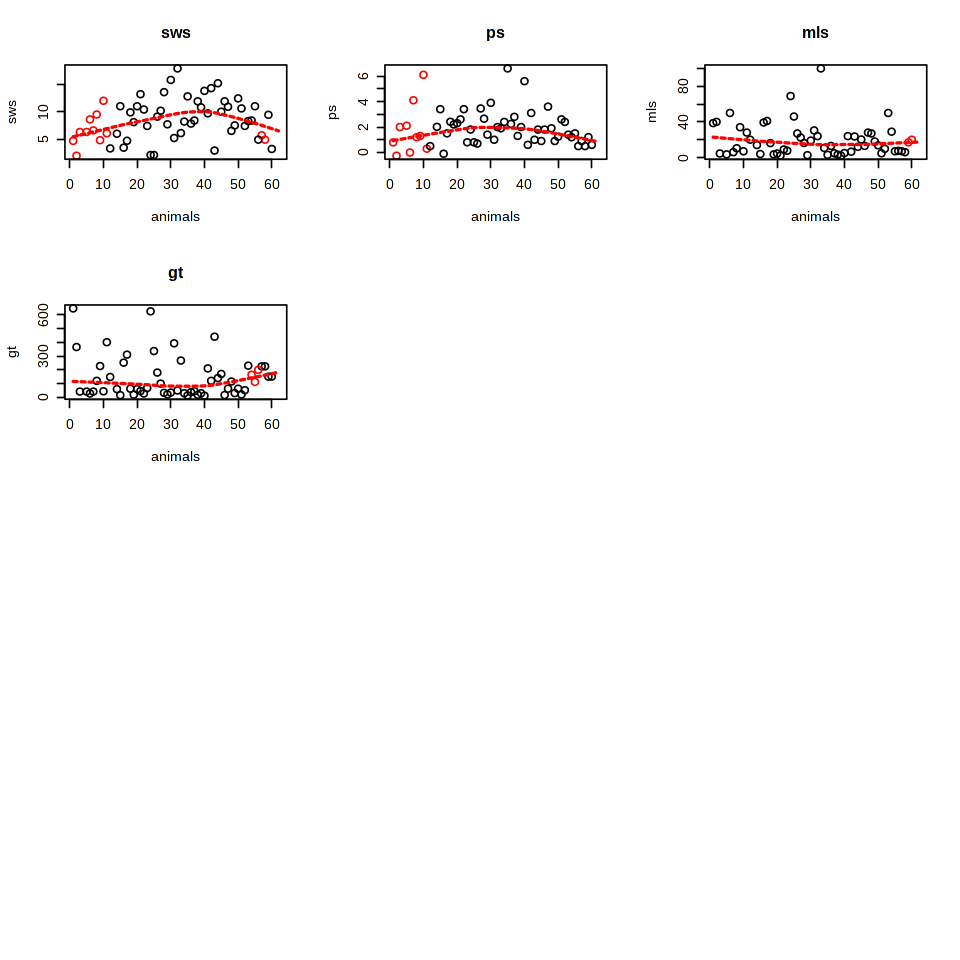

In [33]:
## Visualize the imputed missing values using scatter plots , every red dot is a missing value from the original table
options(repr.plot.width = 8, repr.plot.height = 8)

misspoints <- missingMatrix(animals[idx,])
animals.imp <- data.frame(miss1$imputed.data)
par(mfrow=c(4,3))
for(v in names(animals2)) {
    scatter.smooth(animals.imp[[v]] ~ animals[idx,"species"], main=v, xlab="animals",ylab=v, family="symmetric",
                  lpars =list(col = "red", lwd = 2, lty = 2), col=misspoints[idx,v]+1)
}
par(mfrow=c(1,1))


## MICE: Multiple Imputation with Chained Equations 

In [34]:
# library(mice)
init = mice(animals, maxit=0) 
meth = init$method
predM = init$predictorMatrix

In [35]:
meth

species      bw     brw     sws      ps      ts     mls      gt      pi     sei 
     ""      ""      ""   "pmm"   "pmm"   "pmm"   "pmm"   "pmm"      ""      "" 
    odi 
     ""

In [36]:
predM

,species,bw,brw,sws,ps,ts,mls,gt,pi,sei,odi
species,0,1,1,1,1,1,1,1,1,1,1
bw,1,0,1,1,1,1,1,1,1,1,1
brw,1,1,0,1,1,1,1,1,1,1,1
sws,1,1,1,0,1,1,1,1,1,1,1
ps,1,1,1,1,0,1,1,1,1,1,1
ts,1,1,1,1,1,0,1,1,1,1,1
mls,1,1,1,1,1,1,0,1,1,1,1
gt,1,1,1,1,1,1,1,0,1,1,1
pi,1,1,1,1,1,1,1,1,0,1,1
sei,1,1,1,1,1,1,1,1,1,0,1


In [37]:
### Pedict the missing values
set.seed(103)
imputed = mice(animals, method=meth, predictorMatrix=predM, m=5)


 iter imp variable
  1   1  sws*  ps*  ts*  mls*  gt*
  1   2  sws*  ps*  ts*  mls*  gt*
  1   3  sws*  ps*  ts*  mls*  gt*
  1   4  sws*  ps*  ts*  mls*  gt*
  1   5  sws*  ps*  ts*  mls*  gt*
  2   1  sws*  ps*  ts*  mls*  gt*
  2   2  sws*  ps*  ts*  mls*  gt*
  2   3  sws*  ps*  ts*  mls*  gt*
  2   4  sws*  ps*  ts*  mls*  gt*
  2   5  sws*  ps*  ts*  mls*  gt*
  3   1  sws*  ps*  ts*  mls*  gt*
  3   2  sws*  ps*  ts*  mls*  gt*
  3   3  sws*  ps*  ts*  mls*  gt*
  3   4  sws*  ps*  ts*  mls*  gt*
  3   5  sws*  ps*  ts*  mls*  gt*
  4   1  sws*  ps*  ts*  mls*  gt*
  4   2  sws*  ps*  ts*  mls*  gt*
  4   3  sws*  ps*  ts*  mls*  gt*
  4   4  sws*  ps*  ts*  mls*  gt*
  4   5  sws*  ps*  ts*  mls*  gt*
  5   1  sws*  ps*  ts*  mls*  gt*
  5   2  sws*  ps*  ts*  mls*  gt*
  5   3  sws*  ps*  ts*  mls*  gt*
  5   4  sws*  ps*  ts*  mls*  gt*
  5   5  sws*  ps*  ts*  mls*  gt*
 * Please inspect the loggedEvents 


Warning message:
“Number of logged events: 275”

In [38]:
summary(imputed)

Class: mids
Number of multiple imputations:  5 
Imputation methods:
species      bw     brw     sws      ps      ts     mls      gt      pi     sei 
     ""      ""      ""   "pmm"   "pmm"   "pmm"   "pmm"   "pmm"      ""      "" 
    odi 
     "" 
PredictorMatrix:
        species bw brw sws ps ts mls gt pi sei odi
species       0  1   1   1  1  1   1  1  1   1   1
bw            1  0   1   1  1  1   1  1  1   1   1
brw           1  1   0   1  1  1   1  1  1   1   1
sws           1  1   1   0  1  1   1  1  1   1   1
ps            1  1   1   1  0  1   1  1  1   1   1
ts            1  1   1   1  1  0   1  1  1   1   1
Number of logged events:  275 
  it im dep meth
1  1  1 sws  pmm
2  1  1 sws  pmm
3  1  1 sws  pmm
4  1  1  ps  pmm
5  1  1  ps  pmm
6  1  1  ps  pmm
                                                                                                                                                                                                                                    

In [39]:
summary(imputed$imp)
imp1 <- complete(imputed,1)
dim(imp1)

        Length Class      Mode
species 5      data.frame list
bw      5      data.frame list
brw     5      data.frame list
sws     5      data.frame list
ps      5      data.frame list
ts      5      data.frame list
mls     5      data.frame list
gt      5      data.frame list
pi      5      data.frame list
sei     5      data.frame list
odi     5      data.frame list

[1] 62 11

In [40]:
imputed.full <- complete(imputed,action="long")
dim(imputed.full)

[1] 310  13

In [41]:
## Check if there are any missing on the imputed data
sapply(imputed, function(x) sum(is.na(x)))

Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'language'”

data             imp               m           where          blocks 
             38               0               0               0               0 
           call            nmis          method predictorMatrix   visitSequence 
              0               0               0               0               0 
       formulas            post           blots            seed       iteration 
              0               0               0               1               0 
  lastSeedValue       chainMean        chainVar    loggedEvents         version 
              0             150             150               0               0 
           date 
              0

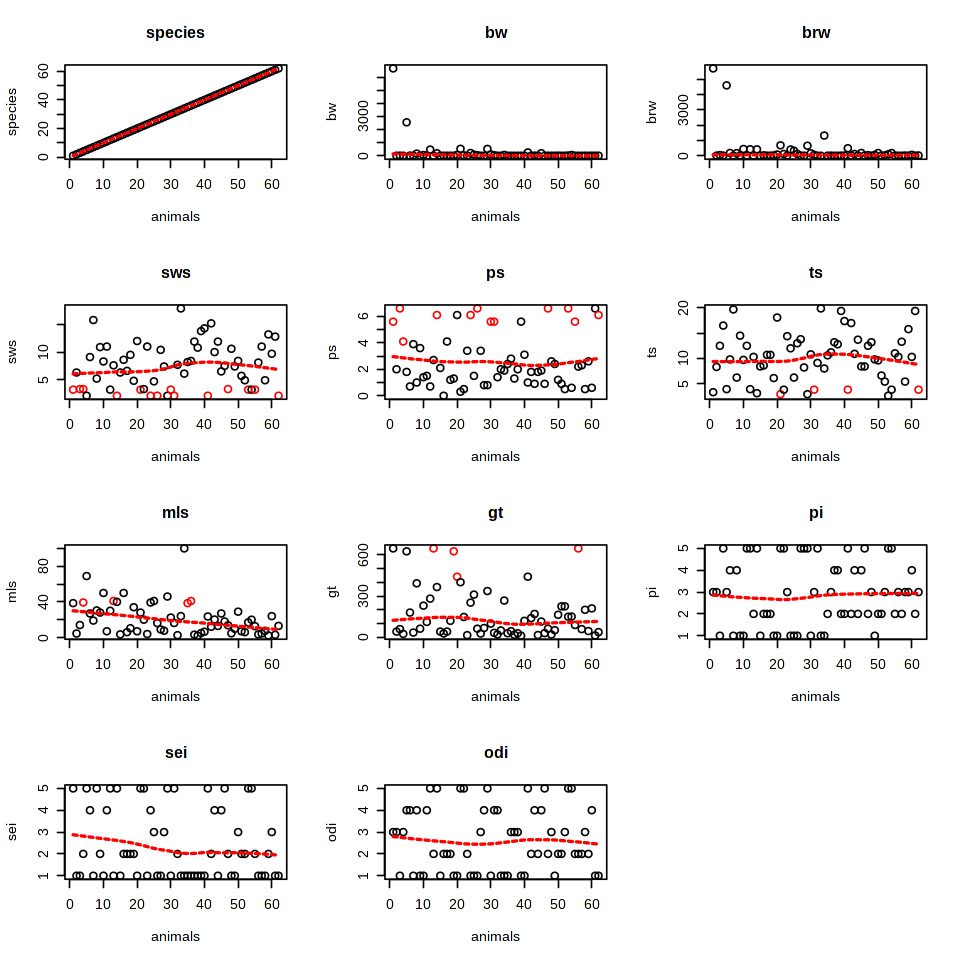

In [42]:
options(repr.plot.width = 8, repr.plot.height = 8)

misspoints <- missingMatrix(animals)
animals.imp <- complete(imputed,1)
par(mfrow=c(4,3))
for(v in names(animals)) {
    scatter.smooth(animals.imp[[v]] ~ animals[,"species"], main=v, xlab="animals",ylab=v, family="symmetric",
                  lpars =list(col = "red", lwd = 2, lty = 2), col=misspoints[,v]+1)
}
par(mfrow=c(1,1))


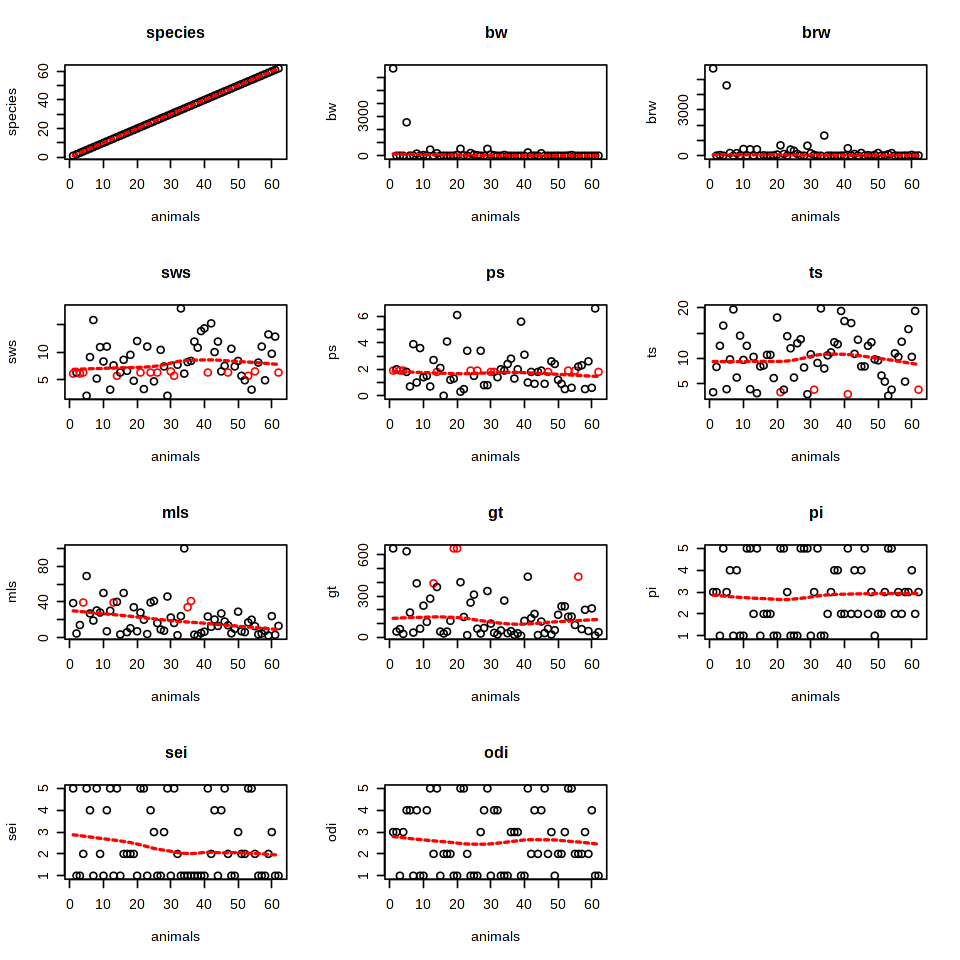

In [43]:
options(repr.plot.width = 8, repr.plot.height = 8)

misspoints <- missingMatrix(animals)
animals.imp <- complete(imputed,5)
par(mfrow=c(4,3))
for(v in names(animals)) {
    scatter.smooth(animals.imp[[v]] ~ animals[,"species"], main=v, xlab="animals",ylab=v, family="symmetric",
                  lpars =list(col = "red", lwd = 2, lty = 2), col=misspoints[,v]+1)
}
par(mfrow=c(1,1))


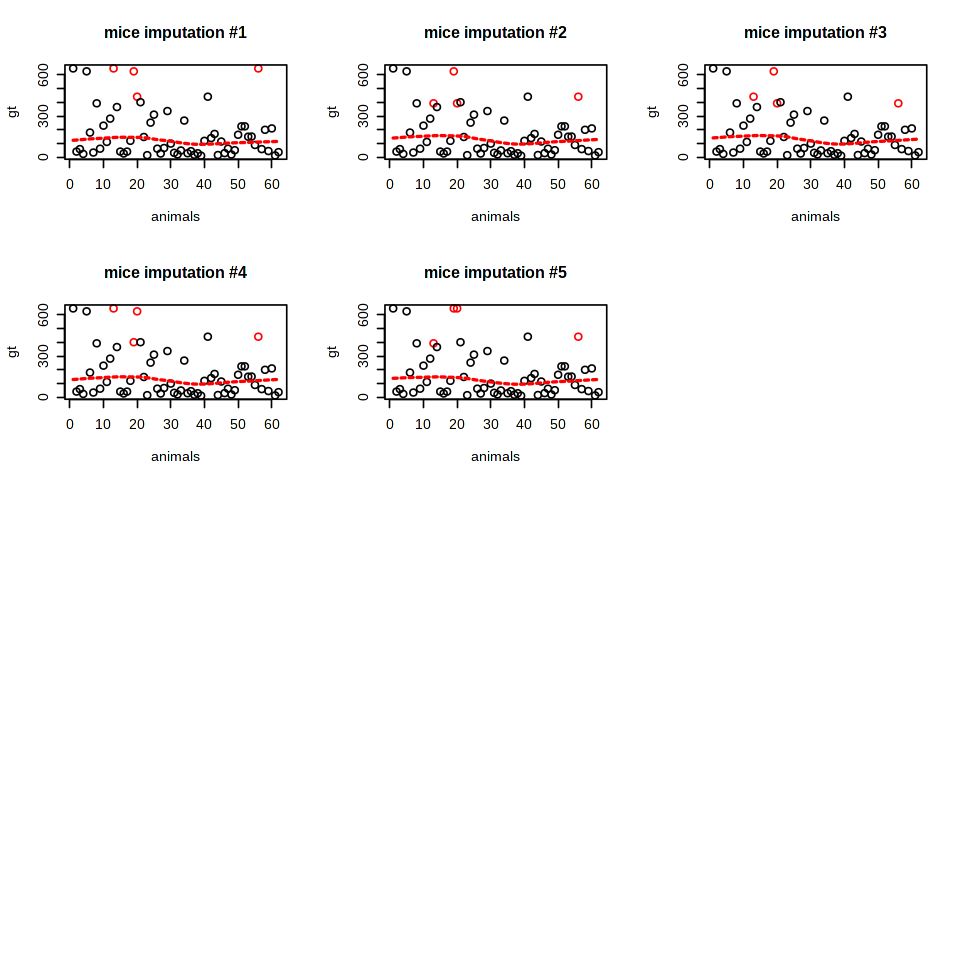

In [44]:
### gt on each of the five imputations
par(mfrow=c(4,3))

## mice imputation #1
scatter.smooth(complete(imputed,1)[["gt"]] ~ animals[,"species"], main="mice imputation #1", xlab="animals",ylab="gt", family="symmetric",
                  lpars =list(col = "red", lwd = 2, lty = 2), col=misspoints$gt+1)

## mice imputation #2
scatter.smooth(complete(imputed,2)[["gt"]] ~ animals[,"species"], main="mice imputation #2", xlab="animals",ylab="gt", family="symmetric",
                  lpars =list(col = "red", lwd = 2, lty = 2), col=misspoints$gt+1)

## mice imputation #3
scatter.smooth(complete(imputed,3)[["gt"]] ~ animals[,"species"], main="mice imputation #3", xlab="animals",ylab="gt", family="symmetric",
                  lpars =list(col = "red", lwd = 2, lty = 2), col=misspoints$gt+1)

## mice imputation #4
scatter.smooth(complete(imputed,4)[["gt"]] ~ animals[,"species"], main="mice imputation #4", xlab="animals",ylab="gt", family="symmetric",
                  lpars =list(col = "red", lwd = 2, lty = 2), col=misspoints$gt+1)

## mice imputation #5
scatter.smooth(complete(imputed,5)[["gt"]] ~ animals[,"species"], main="mice imputation #5", xlab="animals",ylab="gt", family="symmetric",
                  lpars =list(col = "red", lwd = 2, lty = 2), col=misspoints$gt+1)

par(mfrow=c(1,1))


# Propensity Score

In [50]:
## require(MatchIt)

animals2 <- animals[,c('species', 'bw', 'brw', 'pi', 'sei', 'odi')]
animals2$sws_miss <- ifelse(is.na(animals$sws)==T, 1, 0)
summary(animals2)

                      species         bw                brw         
 African elephant         : 1   Min.   :   0.005   Min.   :   0.14  
 African giant pouched rat: 1   1st Qu.:   0.600   1st Qu.:   4.25  
 Arctic Fox               : 1   Median :   3.342   Median :  17.25  
 Arctic ground squirrel   : 1   Mean   : 198.790   Mean   : 283.13  
 Asian elephant           : 1   3rd Qu.:  48.203   3rd Qu.: 166.00  
 Baboon                   : 1   Max.   :6654.000   Max.   :5712.00  
 (Other)                  :56                                       
       pi             sei             odi           sws_miss     
 Min.   :1.000   Min.   :1.000   Min.   :1.000   Min.   :0.0000  
 1st Qu.:2.000   1st Qu.:1.000   1st Qu.:1.000   1st Qu.:0.0000  
 Median :3.000   Median :2.000   Median :2.000   Median :0.0000  
 Mean   :2.871   Mean   :2.419   Mean   :2.613   Mean   :0.2258  
 3rd Qu.:4.000   3rd Qu.:4.000   3rd Qu.:4.000   3rd Qu.:0.0000  
 Max.   :5.000   Max.   :5.000   Max.   :5.000   Max

In [51]:
m.out <- matchit(sws_miss ~ bw + brw + pi + sei + odi, data = animals2, method = "nearest", ratio = 1)
summary(m.out)



Call:
matchit(formula = sws_miss ~ bw + brw + pi + sei + odi, data = animals2, 
    method = "nearest", ratio = 1)

Summary of balance for all data:
         Means Treated Means Control SD Control Mean Diff eQQ Med eQQ Mean
distance        0.3334        0.1944     0.1161    0.1389  0.0994   0.1380
bw            573.3788       89.5349   376.8333  483.8439 33.9900 374.4130
brw           589.7571      193.7025   687.8002  396.0546 98.6500 202.4236
pi              3.0000        2.8333     1.4192    0.1667  0.0000   0.2857
sei             3.1429        2.2083     1.4869    0.9345  1.0000   1.0000
odi             2.7857        2.5625     1.3669    0.2232  0.0000   0.3571
           eQQ Max
distance    0.4836
bw       4107.0000
brw      1109.0000
pi          1.0000
sei         3.0000
odi         1.0000


Summary of balance for matched data:
         Means Treated Means Control SD Control Mean Diff eQQ Med eQQ Mean
distance        0.3334        0.2812     0.1186    0.0522  0.0026   0.0546
bw 

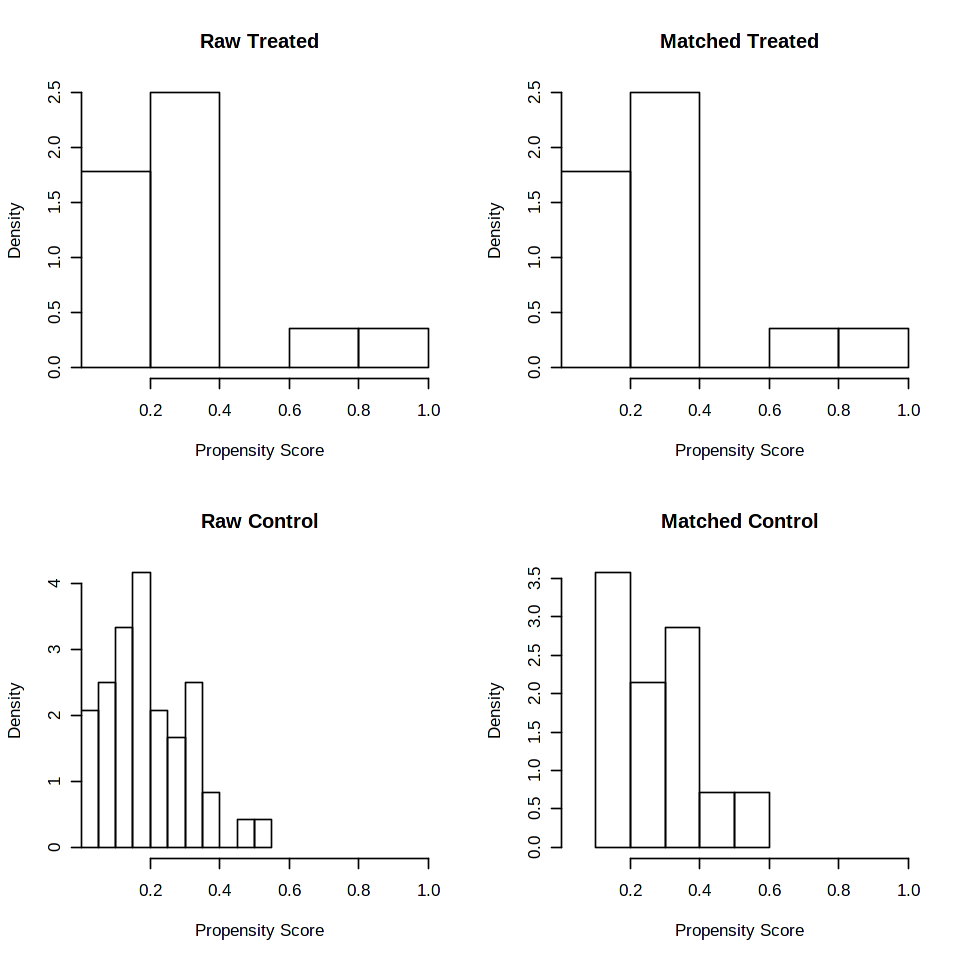

In [52]:
  options(repr.plot.width = 8, repr.plot.height = 8)
plot(m.out, type = "hist")

The MatchIt package has many methods for propensity score matching:
 
1. "exact" - matches each treated unit with a control unit that has exactly the same values on each covariate.
2. "subclass" - breaks the data set into subclasses such that the distributions of the covariates are similar in each subclass 
3. "nearest" - matches a treated unit to a control unit by means of that is closest in terms of a distance measure (nearest neighbor)
4. "optimal" - focuses on minimizing the average absolute distance across all matched pairs 
5. "genetic" - uses a computationally intensive genetic search algorithm to match treatment and control units 
6. "cem" - (Coarsened Exact Matching) matches on a covariate while maintaining the balance of other covariates
 


In [53]:
animals.matched <- match.data(m.out) 
animals.matched %>% arrange(distance)


species,bw,brw,pi,sei,odi,sws_miss,distance,weights
Asian elephant,2547.000,4603.0,3,5,4,0,0.1364069,1
Gray wolf,36.330,119.5,1,1,1,1,0.1446241,1
Red fox,4.235,50.4,1,1,1,0,0.1484034,1
Arctic Fox,3.385,44.5,1,1,1,1,0.1491213,1
Jaguar,100.000,157.0,1,1,1,1,0.1520995,1
Eastern American mole,0.075,1.2,1,1,1,0,0.1551043,1
Raccoon,4.288,39.2,2,2,2,1,0.1833494,1
Echidna,3.000,25.0,2,2,2,0,0.1855885,1
Rock hyrax (Hetero. b),0.750,12.3,2,2,2,0,0.1873356,1
Slow loris,1.400,12.5,2,2,2,1,0.1874609,1
